<style>
    .text_cell_render
    font-family: Times New Roman, serif
    </style>
    <font color='Black'><font size="5">Encontrar modelo de distribucion de la  senal de MNase-coupled a Gcn4 y predecir posibles interacciones de Gcn4 con dif erentes CoActivators</font>

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import scipy 
import seaborn as sns
import scipy.stats as st

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from numpy import NaN, Inf, arange, isscalar, asarray, array

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Lee archivo de Github</font>

In [2]:
def getFromGit(link):
    
        from html2text import html2text
        import requests
    
        f = requests.get(link)
    
        return f.text.encode('ascii','replace')

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">Dictionary of Roman Numbers. Will be used to access each chromosome faster</font>

In [3]:
roman_numbers = {'I':'1','II':'2','III':'3','IV':'4','V':'5','VI':'6','VII':'7',\
                 'VIII':'8','IX':'9','X':'10','XI':'11','XII':'12','XIII':'13','XIV':'14',\
                 'XV':'15','XVI':'16','XVII':'17','M':'M'}

inv_roman = {v: k for k, v in roman_numbers.iteritems()}

promoter_length = 600

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Definir el promoter length y abrir SGD dataset</font>

In [4]:
def open_sgd(promoter_length):

    # open sgd file into a dataframe
    sgd, m = getFromGit('https://raw.githubusercontent.com/aerijman/gcn4_ChEC/master/SGD.tsv'), []
    for i in sgd.split('\n'):
        m.append(i.strip().split('\t'))
    sgd = pd.DataFrame(m)    
    #sgd = pd.read_csv('./SGD.tsv', delimiter='\t')

    #assign column names and use only the 'ORF' rows
    sgd.columns = ['n0','ORF_or_what','n1','locus','gene','n2','n3','n4'\
                  ,'chromosome','start','stop','W/C','n5','n6','n7','n8']
    sgd = sgd[sgd['ORF_or_what']=='ORF']
    
    # get rid of non-informative columns and 2-micron chromosome
    sgd = sgd.drop(['ORF_or_what','n0','n1','n2','n3','n4','n5','n6','n7','n8'],1).set_index('locus')
    sgd = sgd.ix[sgd.chromosome!='2-micron']

    # -1 to Creek and 1 to Watson
    sgd.loc[sgd['W/C']=='C', 'W/C']=-1
    sgd.loc[sgd['W/C']=='W', 'W/C']=1
    
    sgd[['start','stop','W/C']] = sgd[['start','stop','W/C']].apply(pd.to_numeric) 
    
    # create the column 'start promoter' and replace negative numbers \
    # with 0 (promoters that are <600bp form the start of the chromosome)
    sgd['start_promoter'] = sgd['start']-(sgd['W/C']*promoter_length)
    sgd.loc[sgd['start_promoter']<0,'start_promoter']=0

    #sgd['promoter_median'] = (sgd['start'] + sgd['start_promoter']) / 2
    #sgd = sgd.sort_values(['chromosome','promoter_median'])
    #sgd.reset_index(inplace=True)

    return sgd

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='black'><font size="4">700bp porque hay promotores con peaks que si no terminan, el area computada es bastante incorrecta.
    testear y evaluar si conviene dejar aparte los genes que comparten promoter hasta 700bp</font>

In [5]:
sgd = open_sgd(promoter_length)
sgd = sgd[sgd.chromosome.isin(map(str,range(1,17)))]

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:334: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning


<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Abrir wiggle file</font>

In [6]:
def open_wig(wigfile):

# Open the wig file and make a pointer to where each chromosomes start
    #wig, w_pointer = [i.strip('\n').split('\t')[:2] for i in open(wigfile)], {} # this was for opening files, not from github  
    wig, w_pointer = wigfile, {}
    wig2, n = [], 0
    for i in wig[1:]:
        if len(i)==1:
            w_pointer[roman_numbers[i[0][22:]]] = n

        else:
            if int(i[1])>=0:                   ## era >=20...
                wig2.append(i)
                n+=1
        
    # the last pointer to the end of the file, when looking for a gene in chromosome 17 and there is no NEXT chromosome
    #w_pointer['17']=n 

    # wig into dataframe
    wig = pd.DataFrame(wig2)
    wig.columns = ['position','reads']

    return wig, w_pointer

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Dado el locus, devuelve los counts de wiggle</font>

In [7]:
def retrieve_positions(locus, sgd, wig, w_pointer):

    # chromosomes as pointer for the wig file
    this_chromosome = int(sgd[sgd.index==locus].values[0][1])
    this = w_pointer[str(this_chromosome)]

    # assign the key to NOT to be the current chromosome
    key = [1 if this_chromosome>7 else 10][0]

    # Now go and find me the closest chromosome in the wig file (they are not in order!!)
    for i,j in w_pointer.iteritems():
        if j-this < abs(w_pointer[str(key)]-this) and j>this and i != this_chromosome:
            key = i 
    next = w_pointer[str(key)]

    # promoter positions to find in the wig 
    promoter_positions = [int(i) for i in sgd[sgd.index==locus][['start_promoter', 'start']].as_matrix()[0]]
    
    # In case the gene is in the Creek direction
    if sgd[sgd.index==locus]['W/C'].values[0]==-1:
        promoter_positions = [promoter_positions[1],promoter_positions[0]]

    # restricting the wig to the chromosome and the positions 
    Gene_df =  wig[(wig.index > this) & (wig.index < next)]

    # Only if the wig file contains counts for this gene, otherwise return False!
    if Gene_df.position.empty == False:
        Gene_df = Gene_df[(Gene_df.position.astype(int)>promoter_positions[0]) & (Gene_df.position.astype(int)<promoter_positions[1])]
        return Gene_df.astype(int)
    else:
        return pd.DataFrame([])

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Dado el locus, devuelve los counts de wiggle del promoter or ORF</font>

In [8]:
def retrieve_wiggle(locus, sgd, wig, w_pointer, region='promoter'):

    # chromosomes as pointer for the wig file
    this_chromosome = int(sgd[sgd.index==locus].values[0][1])
    this = w_pointer[str(this_chromosome)]

    # assign the key to NOT to be the current chromosome
    key = [1 if this_chromosome>7 else 10][0]

    # Now go and find me the closest chromosome in the wig file (they are not in order!!)
    for i,j in w_pointer.iteritems():
        if j-this < abs(w_pointer[str(key)]-this) and j>this and i != this_chromosome:
            key = i 
    next = w_pointer[str(key)]

    # promoter positions to find in the wig 
    A = sgd[sgd.index==locus]['start'].values[0]
    B = (A + promoter_length*sgd.loc[sgd.index==locus,'W/C'][0]) if region=='orf' else (A - promoter_length*sgd.loc[sgd.index==locus,'W/C'][0])
    promoter_positions = [A,B] if region=='orf' else [B,A]
    
    # In case the gene is in the Creek direction
    if sgd[sgd.index==locus]['W/C'].values[0]==-1:
        promoter_positions = [promoter_positions[1],promoter_positions[0]]

    # restricting the wig to the chromosome and the positions 
    Gene_df =  wig[(wig.index > this) & (wig.index < next)]

    # Only if the wig file contains counts for this gene, otherwise return False!
    if Gene_df.position.empty == False:
        Gene_df = Gene_df[(Gene_df.position.astype(int)>promoter_positions[0]) & (Gene_df.position.astype(int)<promoter_positions[1])]
        return Gene_df.astype(int)
    else:
        return pd.DataFrame([])

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: Busco la bw optima para el kernel</font>

In [9]:
def find_Kernel_best_bandwidth(x,y):

    # Prepare "histogram-like" data
    histo = []
    for i in range(len(y)):
        for j in range(y[i]):
            histo.append(x[i])
    histo = np.array(histo)
        
    #Check which is the best bandwidth to use with 20 steps of cross-validation
    grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace(10,300,30)}, cv=9)
    grid.fit(histo[:,None])

    return grid.best_params_.values()[0]

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC: devuelve PDF <font size="3"> (if not provided bandwidth, ot calculates the optimal)</font>

In [10]:
def kernelPDF(x, y, bandwidth=0, kernel_choose='epanechnikov'):
    
    #print args
    # Prepare "histogram-like" data
    histo = []
    for i in range(len(y)):
        for j in range(y[i]):
            histo.append(x[i])

    histo = np.array(histo)
    
    #busco la optima bw si no esta definida como argumento
    if locals()['bandwidth']==0:
        bandwidth = np.std(histo)*(4/(3.0*len(histo)))**(1/5)
        
        #puedo buscarla con cross-validation minimizando la MISE, que seria la mejor manera, pero tarda mucho...
        #grid = GridSearchCV(KernelDensity(kernel=kernel_choose),{'bandwidth': np.linspace(10,300,30)}, cv=9)
        #grid.fit(histo[:,None])
        #bandwidth = grid.best_params_.values()[0]
    
    print "best_bw = ", locals()['bandwidth']
    
    # Kernel Density Estimation with Scikit-learn
    kde = KernelDensity(kernel=kernel_choose, bandwidth=bandwidth).fit(histo[:,np.newaxis])
    pdf = np.exp(kde.score_samples(x[:,np.newaxis]))
    
    return pdf

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC:calculo MISE $\int_{a}^{b} f(x) e^{2\pi i k} dx'))$ por ahora solo calculo el factor Silverman</font>

In [11]:
 def silverman(histo):
        n,d = len(histo), np.ndim(histo)
        print "Just to check up... Data is taken as 1d"    
        return (n * (d + 2) / 4.)**(-1. / (d + 4))

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">FUNC:pre-process data, call kernelPDF and return normalized pdf</font>

In [12]:
def normed_PDF(gene, all_df, bandwidth=0, kernel_choose='epanechnikov'):
    
    # normalize the wiggle data
    #gene_df.loc[:,'norm_reads'] = ((gene_df.loc[:,'reads']-gene_df.reads.min())/(gene_df.reads.max()-gene_df.reads.min()))
    #orf_df.loc[:,'norm_reads'] = ((orf_df.loc[:,'reads']-orf_df.reads.min())/(orf_df.reads.max()-orf_df.reads.min()))
    #all_df.loc[:,'norm_reads'] = ((all_df.loc[:,'reads']-all_df.reads.min())/(all_df.reads.max()-all_df.reads.min()))

    # sort the data towards the pdf modeling
    all_df.sort_values(by='position', inplace=True)

    (x,y) =  zip(*[(i[0], i[1]) for i in all_df[['position','reads']].values])
    x,y = np.array(x, dtype=int), np.array(y, dtype=int)

    # best_bw = find_Kernel_best_bandwidth(x,y)
    pdf = kernelPDF(x,y,bandwidth,kernel_choose='epanechnikov')

    # Normalizo y    
    y = [(i*1.0-np.min(y))/(np.max(y)-np.min(y)) for i in y]
    pdf = [(i-np.min(pdf))/(np.max(pdf)-np.min(pdf)) for i in pdf]
    # return values of x,y and the normalized pdf
    return x, y, pdf

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">Incluyo TSSs al df</font>

In [27]:
tss, m = getFromGit('https://raw.githubusercontent.com/aerijman/gcn4_ChEC/master/tss.csv'), []
for i in tss.split('\n'):
    m.append(i.strip().split(','))
tss = pd.DataFrame(m[1:], columns=m[0]).ix[:,1:]    
tss[['TSS_start','TSS_frecuency_YPD']] = tss[['TSS_start','TSS_frecuency_YPD']].apply(pd.to_numeric)
#tss = pd.read_csv('tss.csv').ix[:,1:]
tss.set_index('id', inplace=True)
sgd = pd.concat([sgd,tss], axis=1)
sgd.dropna(subset = ['start', 'stop', 'chromosome'], inplace=True)
sgd.head()

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning


,gene,chromosome,start,stop,W/C,start_promoter,TSS_start,TSS_frecuency_YPD
YAL001C,TFC3,1,151166.0,147594.0,-1.0,151766.0,151198.0,1.0
YAL002W,VPS8,1,143707.0,147531.0,1.0,143107.0,143612.0,2.0
YAL003W,EFB1,1,142174.0,143160.0,1.0,141574.0,142153.0,5215.0
YAL004W,,1,140760.0,141407.0,1.0,140160.0,137649.0,1.0
YAL005C,SSA1,1,141431.0,139503.0,-1.0,142031.0,141493.0,855.0


<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <meta http-equiv="Content-Type" content="text/html; charset=ISO-8859-1">
    <font color='blue'><font size="5">Incorporate from Zhang those incorrect or missing TSSs @ Pelechano</font>

In [28]:
t = getFromGit('https://raw.githubusercontent.com/aerijman/gcn4_ChEC/master/tss_zhang.csv')
mat=[]
for line in t.split('\n'):
    i = line.strip().split(',')
    mat.append(i)

zhang_df = pd.DataFrame(mat)
zhang_df.columns = zhang_df.iloc[0]
zhang_df.set_index('locus', inplace=True)
zhang_df = zhang_df.iloc[1:]

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning


In [29]:
list_of_start_TSS_dist_above_1000 = sgd.loc[sgd.start - sgd.TSS_start > 1000]
list_of_TSS_after_start = sgd.loc[(sgd.start - sgd.TSS_start) * sgd['W/C'] <0]
sgd_no_Pelechano = sgd.loc[(((sgd.start - sgd.TSS_start) * sgd['W/C'] >0) & (sgd.start - sgd.TSS_start < 1000)) | (sgd.TSS_start==np.NaN)]

zhang_add_2_sgd = zhang_df[zhang_df.index.isin(sgd_no_Pelechano.index)==False].index

for i in zhang_add_2_sgd:
    sgd.loc[i,['TSS_start','TSS_frecuency_YPD']] = zhang_df.loc[i,['start','max(frecuency)']].as_matrix()
    
sgd.dropna(inplace=True)
sgd[['TSS_start','TSS_frecuency_YPD']] = sgd[['TSS_start','TSS_frecuency_YPD']].apply(pd.to_numeric)

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <font color='blue'><font size="5">Leo wiggle de Github y lo almaceno en una df</font>

In [30]:
wig = getFromGit('https://raw.githubusercontent.com/aerijman/gcn4_ChEC/master/extremes_27.wig')

mat=[]
for i in wig.split('\n'):
    mat.append(i.strip().split('\t')[:2])
    
df_wig, pointer_wig = open_wig(mat[:-1])

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning


<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <meta http-equiv="Content-Type" content="text/html; charset=ISO-8859-1">
    <font color='blue'><font size="5">Calculo pdf de la se&ntilde;al en promoter+orf y plot </font>

best_bw =  90
ILV6 [ 0.     0.002  0.003  0.006  0.006]
[ 0.02   0.012  0.009  0.007  0.006]
best_bw =  90
PCL5 [ 0.577  0.585  0.601  0.611  0.621]
[ 0.046  0.044  0.044  0.043  0.04 ]


/home/ariel/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


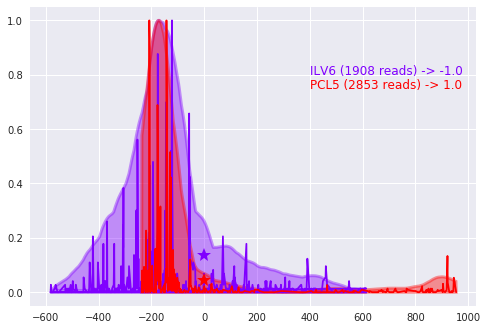

In [31]:
genes = ['ILV6','PCL5']#['ARG3','HIS4','ARG1','STR3','ALD5','ILV6','PCL5']
colors = plt.cm.rainbow(np.linspace(0, 1, len(genes)))
move_Y_legend=0
#plt.figure(figsize=(20,10))    

for color,gene in zip(colors,genes):
    
    # Generate df with wiggle data for promoter and orf
    gene_df = retrieve_wiggle(sgd[sgd.gene==gene].index[0], sgd, df_wig, pointer_wig, region='promoter')
    orf_df = retrieve_wiggle(sgd[sgd.gene==gene].index[0], sgd, df_wig, pointer_wig, region='orf')
    all_df = pd.DataFrame(pd.concat([gene_df,orf_df], axis=0))

    # puedo llamar a la funcion asignando el bw(seria el tercer argumento en normed_PDF)
    x, y, pdf = normed_PDF(gene, all_df,bandwidth=90, kernel_choose='epanechnikov')
    #all_df.plot.area(x='position',y='norm_reads',  alpha=0.5, color='gray')
    
    
    
    
    # Evaluar que la pdf empiece y termine en <0.01. Si no, actualizar el promoter_length
    # aumentando el # de nucleotidos hacia uno o los dos lados hasta que empieze y termine con menos de 0.01.
    
    print gene,np.round(pdf[:5],3)
    print np.round(pdf[-5:],3)

    
    
    
    
    # TSS value and center the pdf around the TSS
    tss = sgd.loc[sgd.gene==gene, 'TSS_start'].values[0]
    x = [i-tss for i in x]
    # if reverse direction, reverse it to compare it to the others
    if int(sgd.loc[sgd.gene==gene,'W/C'].values[0])==-1:
         #pdf = pdf[::-1]
         x = [i*-1 for i in x]#[::-1]
         #y = y[::-1]
    
    #cerear los exremos de las curvas:
    x = np.insert(x,0,np.min(x)-1) # Al comienzo
    x = np.insert(x,len(x),np.max(x)+1) # y al final
    
    pdf = np.insert(pdf,0,0) # Al comienzo
    pdf = np.insert(pdf,len(pdf),0) # Al final
    
    y = np.insert(y,0,0) # Al comienzo
    y = np.insert(y,len(y),0) # y al final

    
    # obtengo datos sobre la curva..
    stat_array = st.describe(np.array([k for k in zip(x,pdf)])) #if k[1]>5]))
    #for i in stat_array:
    #    print i]
    
    plt.fill(x,pdf, color=color, lw=3, alpha=0.4)
    plt.plot(x,y, color=color)
    plt.annotate(''.join([gene,' (', str(all_df.reads.sum()), ' reads) -> ',str(sgd.loc[sgd.gene==gene,'W/C'].values[0])]), xy=(400,0.8+move_Y_legend), color=color)
    move_Y_legend -=0.05
    plt.plot(0,np.median(y)*10, '*', color=color, markersize=15)

<style>
    .text_cell_render
    font-family: Times New Roman, serif
</style>
    <meta http-equiv="Content-Type" content="text/html; charset=ISO-8859-1">
    <font color='red'><font size="5">Si extiendo el adn linear, cuantas bp ocupar&iacute;a gcn4 solo o con co-activators? </font>

<font size='4', color='red'>Elimino genes en los que TSS esta en el ORF o dist[tss-start] > 1000bp?

</font>

<font size='5', color='blue'>Habra correlacion entre las frecuencias de TSS con los valores de nasc. mRNA?</font>

In [18]:
t = getFromGit('https://raw.githubusercontent.com/aerijman/gcn4_ChEC/master/Degron_Log2_table_140.csv') 
mat= []
for line in t.split('\n'):
    i = line.strip().split(',')
    mat.append(i)

nasc_df = pd.DataFrame(mat)

In [19]:
nasc_df.columns = nasc_df.iloc[0]
nasc_df = nasc_df.iloc[1:,]
nasc_df.set_index('Gene_name', inplace=True)

In [20]:
test_df = nasc_df[['WT_control_value','WT_log2_ratio']].astype(float)
test_df = pd.concat([test_df,sgd.TSS_frecuency_YPD],axis=1)

<font><font size="3"><font color="gray">Aparently, there is no correlation at all between TSS_frecuencies @ Pelechano and the WT nascent RNA.</font>

(-100, 5000)

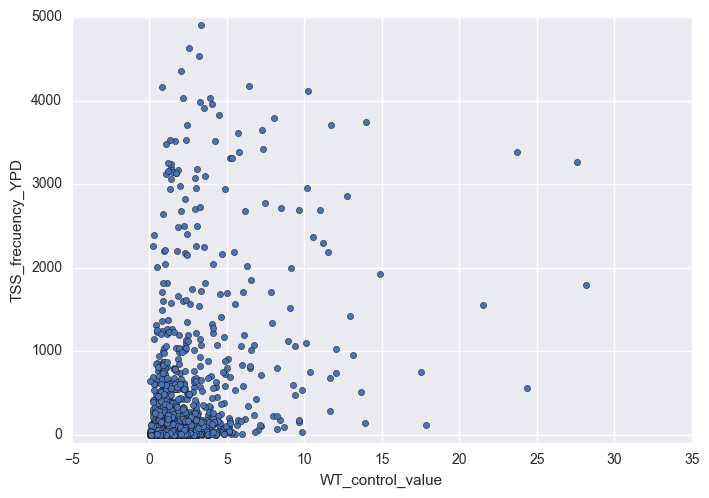

In [21]:
plt.figure()
test_df.plot.scatter(x = 'WT_control_value', y='TSS_frecuency_YPD')
plt.ylim(-100,5000)